In [1]:
import os
import subprocess

java_home = subprocess.check_output(["/usr/libexec/java_home", "-v", "17"]).strip().decode('utf-8')

# Set JAVA_HOME and PATH
os.environ["JAVA_HOME"] = java_home
os.environ["PATH"] = os.path.join(java_home, "bin") + ":" + os.environ["PATH"]
os.environ["PYSPARK_SUBMIT_ARGS"] = "--master local pyspark-shell"

# Verify JAVA_HOME and Java version
print("JAVA_HOME:", os.environ['JAVA_HOME'])
!java -version

JAVA_HOME: /opt/homebrew/Cellar/openjdk@17/17.0.13/libexec/openjdk.jdk/Contents/Home
openjdk version "17.0.13" 2024-10-15
OpenJDK Runtime Environment Homebrew (build 17.0.13+0)
OpenJDK 64-Bit Server VM Homebrew (build 17.0.13+0, mixed mode, sharing)


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder \
    .appName("CBRFSS") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "4") \
    .getOrCreate()


In [4]:
file_path = "output/processedv3.parquet"

df = spark.read.parquet(file_path)

df_filled = df.na.drop()
train_df, test_df = df_filled.randomSplit([0.8, 0.2], seed=1)
# Show the counts of each split
print(f"Training set count: {train_df.count()}")
print(f"Test set count: {test_df.count()}")

In [ ]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import functions as F
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Categorical features
categorical_features = ["EMPLOY1", "ALCDAY4", "FALL12MN"]

# One-Hot Encoding
encoder = OneHotEncoder(
    inputCols=categorical_features,
    outputCols=[feature + "_ohe" for feature in categorical_features],
)

# Fit and transform the encoder on the training data
encoder_model = encoder.fit(train_df)
train_df = encoder_model.transform(train_df)
test_df = encoder_model.transform(test_df)

# Remove original categorical features
train_df = train_df.drop(*categorical_features)
test_df = test_df.drop(*categorical_features)

# Prepare feature columns (include one-hot encoded columns)
feature_columns = [col for col in train_df.columns if col != "y"]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_data = assembler.transform(train_df)
test_data = assembler.transform(test_df)

In [5]:
# Decision tree

decision_tree = DecisionTreeClassifier(featuresCol="features", labelCol="y")

# Set up hyperparameter tuning
paramGrid = (
    ParamGridBuilder()
    .addGrid(decision_tree.maxDepth, [5, 6, 7])
    .addGrid(decision_tree.minInstancesPerNode, [1, 2, 3])
    .build()
)

# Set up cross-validation
evaluator = MulticlassClassificationEvaluator(
    labelCol="y", predictionCol="prediction", metricName="accuracy"
)
crossval = CrossValidator(
    estimator=decision_tree,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,
)

# Train the model using Cross-Validation
cv_model = crossval.fit(train_data)

# Evaluate on the test set
test_predictions = cv_model.transform(test_data)

# Evaluate model accuracy on the test data
test_accuracy = evaluator.evaluate(test_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Extract and display the best decision tree model structure
print(cv_model.bestModel.toDebugString)

# Group predictions by the predicted class
test_predictions.groupBy("prediction").count().show()

Test Accuracy: 0.85
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_88b7a348cd8f, depth=6, numNodes=31, numClasses=2, numFeatures=19
  If (feature 0 <= 2.5)
   If (feature 2 <= 1.5)
    If (feature 10 <= 3.5)
     Predict: 0.0
    Else (feature 10 > 3.5)
     If (feature 7 <= 1.5)
      Predict: 0.0
     Else (feature 7 > 1.5)
      If (feature 3 <= 7.5)
       Predict: 0.0
      Else (feature 3 > 7.5)
       If (feature 4 <= 1.5)
        Predict: 1.0
       Else (feature 4 > 1.5)
        Predict: 0.0
   Else (feature 2 > 1.5)
    If (feature 7 <= 1.5)
     Predict: 0.0
    Else (feature 7 > 1.5)
     If (feature 9 <= 832.5)
      Predict: 0.0
     Else (feature 9 > 832.5)
      If (feature 11 <= 1.5)
       If (feature 14 <= 2.5)
        Predict: 1.0
       Else (feature 14 > 2.5)
        Predict: 0.0
      Else (feature 11 > 1.5)
       Predict: 0.0
  Else (feature 0 > 2.5)
   If (feature 2 <= 1.5)
    Predict: 0.0
   Else (feature 2 > 1.5)
    If (feature 0 <= 3.5)
     

In [6]:
# Evaluate the model's weighted precision
evaluator = MulticlassClassificationEvaluator(labelCol="y", predictionCol="prediction", metricName="weightedPrecision")
weighted_precision = evaluator.evaluate(test_predictions)

print(f"Weighted Precision: {weighted_precision:.4f}")

Feature Importances:
GENHLTH: 0.562620996907235
_RFHYPE6: 0.310232134532652
_RFCHOL3: 0.06592225236184439
_BMI5CAT: 0.03283320773031007
ALCDAY4: 0.009725206985840429
CHCKDNY2: 0.007821971802619707
DIFFWALK: 0.006593399732034565
_INCOMG1: 0.0021671967867831847
EMPLOY1: 0.001347106889465911
_MICHD: 0.0007365262712146444
_AGEG5YR: 0.0
_DRDXAR2: 0.0
_HCVU653: 0.0
METVL12_: 0.0
_TOTINDA: 0.0
EDUCA: 0.0
FALL12MN: 0.0
SMOKE100: 0.0
CVDINFR4: 0.0


In [ ]:
# Feature Importance
importances = cv_model.bestModel.featureImportances
feature_importance = [(name, importance) for name, importance in zip(feature_columns, importances)]
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)
print("Feature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

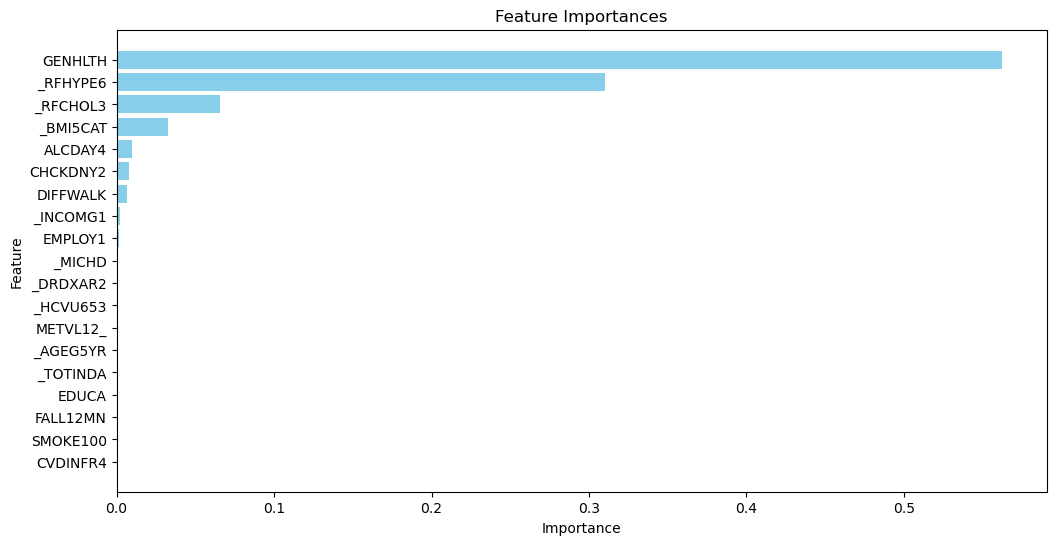

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the feature importances and corresponding feature names
importances = cv_model.bestModel.featureImportances
feature_importance = [(name, importance) for name, importance in zip(feature_columns, importances)]

# Filter out features with zero importance (if any)
non_zero_importance = [(name, importance) for name, importance in feature_importance if importance > 0]

# Sort features by importance (descending order)
sorted_features = sorted(non_zero_importance, key=lambda x: x[1], reverse=True)

# Extract sorted feature names and their importances
sorted_feature_names = [name for name, importance in sorted_features]
sorted_importances = [importance for name, importance in sorted_features]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()
